<a href="https://colab.research.google.com/github/TJTomas/DSPS_TTomaszewski/blob/main/HW8/Tomaszewski_higgsbosonSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
#imports
from google.colab import output
output.enable_custom_widget_manager()

import ipywidgets as ipw
import numpy as np
import pylab as pl
from scipy.cluster.vq import kmeans2
%pylab inline

import json
import os
import pandas as pd
import matplotlib.pyplot as plt

#Sk learn imports
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Correlation matrix
import seaborn as sns

#later on
from numpy import array

# Part 8 Imports
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


Populating the interactive namespace from numpy and matplotlib


In [2]:
#mount your google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [3]:
%cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [4]:
#!ls

In [5]:
# this makes sure the file is there: this cell should return "kaggle.json"
!ls kaggle.json

kaggle.json


In [6]:
# this limits who can view and make changes who can access this file.
!chmod 600 kaggle.json

# this reads in the file and stores it into the system variables of your colab sessions which allows you to connect programmatically to the kaggle platform
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = "e60b57c215e877e01a22375a3058eec1"#envs['key']

In [7]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [8]:
#check that it worked by listing the kaggle datasets
!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset        16151  2025-10-01 16:35:53.273000          17640        607  1.0              
jaderz/hospital-beds-management                                 Hospital Beds Management                                 47583  2025-10-03 09:21:58.590000          14833        352  1.0              
umuttuygurr/e-commerce-customer-behavior-and-sales-analysis-tr  E-Commerce Customer Behavior & Sales Analysis -TR       138245  2025-10-29 13:58:22.810000           1714         37  1.0              


In [9]:
# i suggest you put the data in a folder inside of your dsps folder, which you shoudl already have
%cd dsps

/content/gdrive/My Drive/dsps


In [10]:
!mkdir kaggleHiggsBosonSearch

mkdir: cannot create directory ‘kaggleHiggsBosonSearch’: File exists


In [ ]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  kaggleTitanic		titanic.zip
higgs-boson.zip				 random_submission.zip	training.csv
kaggleHiggsBosonSearch			 test.zip		training.zip


In [11]:
!cd kaggleHiggsBosonSearch/

In [ ]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  kaggleTitanic		titanic.zip
higgs-boson.zip				 random_submission.zip	training.csv
kaggleHiggsBosonSearch			 test.zip		training.zip


In [ ]:
!unzip higgs-boson.zip

Archive:  higgs-boson.zip
replace HiggsBosonCompetition_AMSMetric_rev1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace random_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  kaggleTitanic		titanic.zip
higgs-boson.zip				 random_submission.zip	training.csv
kaggleHiggsBosonSearch			 test.zip		training.zip


In [ ]:
!unzip training.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [12]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [13]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [14]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [15]:
higgsdata.tail()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249995,349995,-999.000,71.989,36.548,5.042,-999.0,-999.0,-999.0,1.392,5.042,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.0,-999.0,-999.0,2.585,22.439,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.0,-999.0,-999.0,2.390,22.183,...,1,41.992,1.8,-0.166,-999.0,-999.0,-999.0,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.0,-999.0,-999.0,2.025,7.479,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.877474,b


In [16]:
higgsdata.shape

(250000, 33)

In [17]:
higgsdata.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [18]:
higgsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

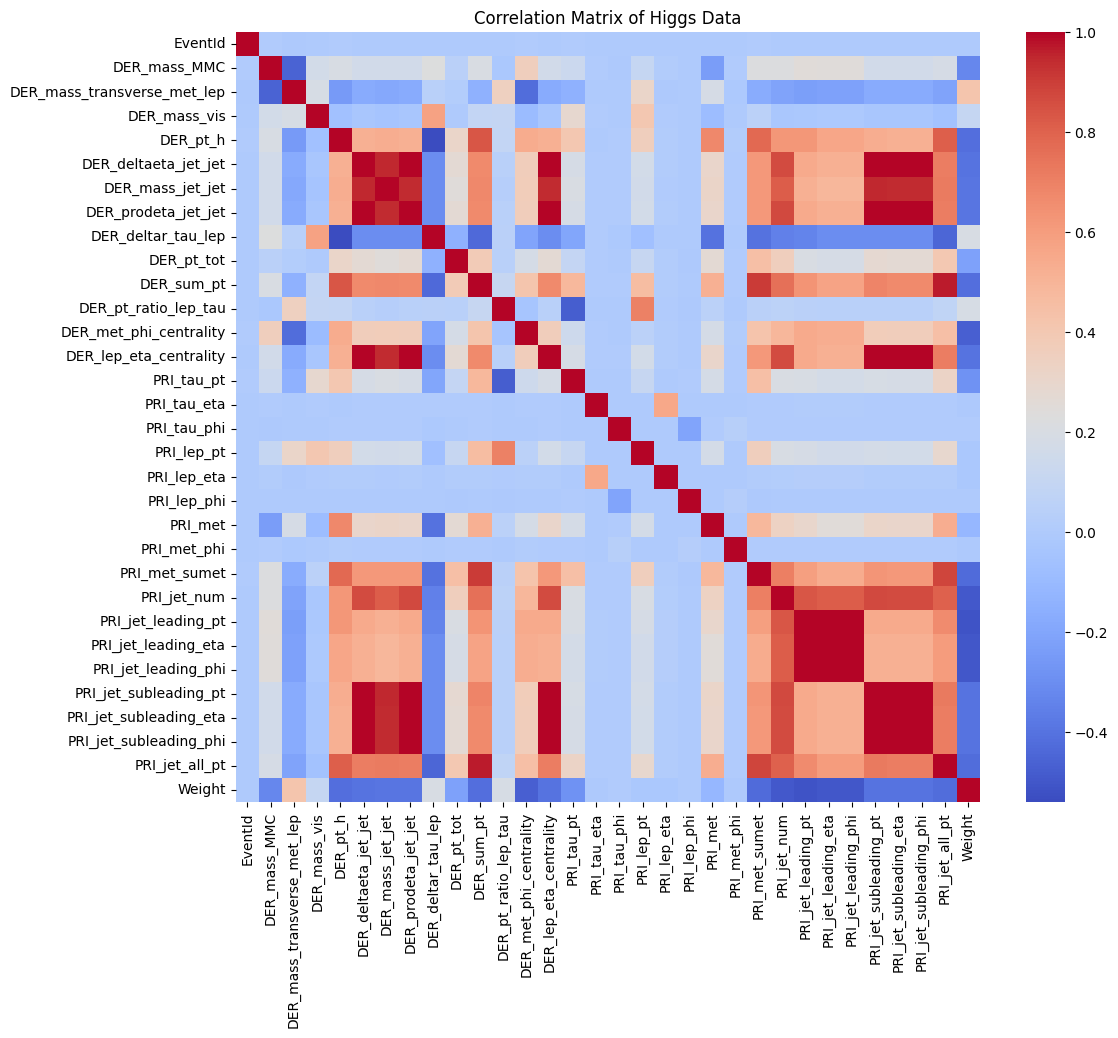

In [21]:
correlation_matrix = higgsdata.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Higgs Data')
plt.show()

# Will need to write something here

Tough shit fuckface

# Task 3: data preparation


- Read in the trainind data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [22]:
training_data = higgsdata.drop(["EventId", "Weight", "Label"], axis=1)

In [23]:
# labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"
labels = higgsdata["Label"]

In [24]:
# weights # the weight of the particle
weights = higgsdata["Weight"]

use the "training.csv" file, but create your own train/test sets

In [25]:
train_x, test_x, train_y, test_y = train_test_split(training_data, labels, test_size=0.3, random_state=42)

In [26]:
train_regress_x, test_regress_x, train_regress_y, test_regress_y = train_test_split(training_data, weights, test_size=0.3, random_state=42)

#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

We did not need to scale the data like we did in cluster models as we do not need to scale the data if we use tree methods like we will below.

# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [27]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [28]:
#now control some hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

In [29]:
gbt = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=0)

In [30]:
rf.fit(train_x, train_y)


RandomForestClassifier(max_depth=10, random_state=0)

In [31]:
gbt.fit(train_x, train_y)

GradientBoostingClassifier(random_state=0)

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [32]:
print(f"the RF scores on the training test is {rf.score(train_x, train_y):.2f}, on the test is {rf.score(test_x, test_y):.2f}")
print("this indicates.....")
print(f"the GBT scores on the training test is {gbt.score(train_x, train_y):.2f}, on the test is {gbt.score(test_x, test_y):.2f}")
print("this indicates....")

the RF scores on the training test is 0.84, on the test is 0.83
this indicates.....
the GBT scores on the training test is 0.83, on the test is 0.83
this indicates....


**Comment** is your model performing well? is it .... overfitting?

- Produce a confusion matrix for each model and compare them






In [33]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
# I creaded this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.1 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.1 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.1 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.1 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

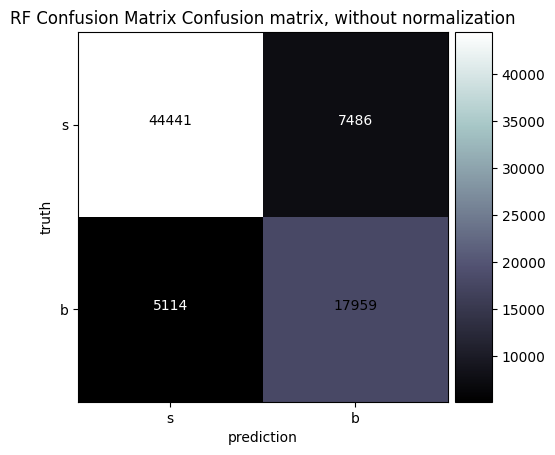

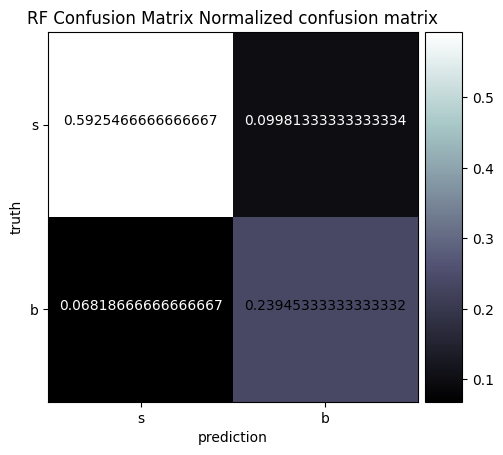

In [36]:
#for RF
plot_confusion_matrix(test_y, rf.predict(test_x), title="RF Confusion Matrix", labels=["b", "s"])
plot_confusion_matrix(test_y, rf.predict(test_x), normalize=True, title="RF Confusion Matrix", labels=["b", "s"])

# Put Captions here later
May god reset our souls

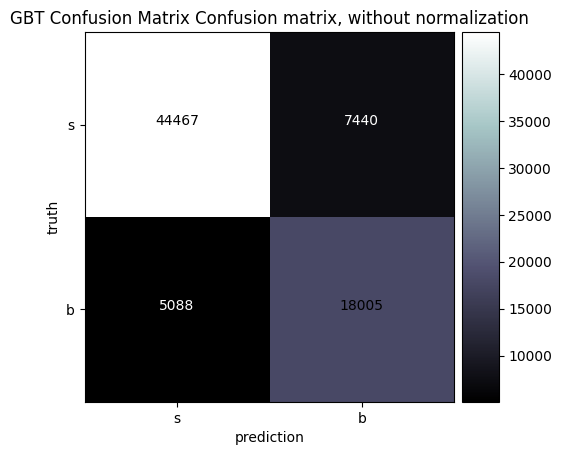

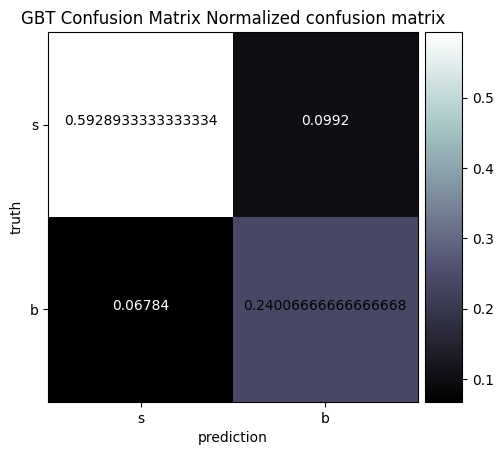

In [38]:
#do the same fo GBT, dont forget your captions!!
plot_confusion_matrix(test_y, gbt.predict(test_x), title="GBT Confusion Matrix", labels=["b", "s"])
plot_confusion_matrix(test_y, gbt.predict(test_x), normalize=True, title="GBT Confusion Matrix", labels=["b", "s"])


# Also put captions here later
please

Plot a simple ROC curve for the RF and GBT models  a d describe it in a caption.

In [50]:
#this will be passed to the ROC function
test_y.values.reshape(-1, 1).flatten() == "s"

array([False, False, False, ..., False, False, False])

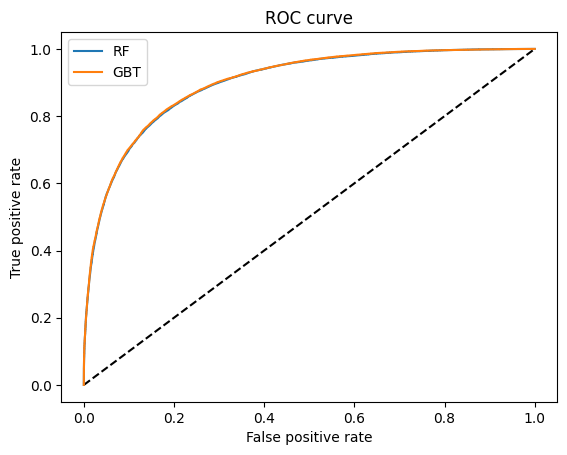

In [55]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [64]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)

RandomForestRegressor(max_depth=3, random_state=302)

In [65]:
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=302)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [66]:
def L1(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def L2(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [67]:
print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 1.00, L2 RF 1.83


In [68]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 0.84, L2 GBT 1.36


#**Discuss!**

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the 4 most important features based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [69]:
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)

In [70]:
best_features_index = sorted_indices[-4:]

In [71]:
higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index[::-1]] #this sorts the data by feature

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'PRI_tau_pt'],
      dtype='object')

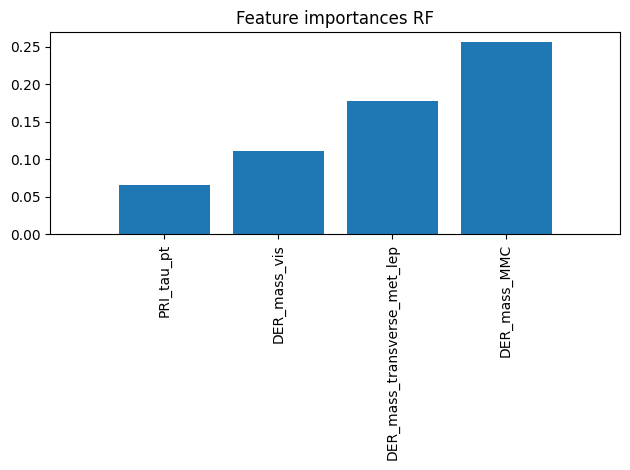

In [72]:
plt.figure()
plt.title("Feature importances RF")
plt.bar(range(len(best_features_index)), feature_importances[best_features_index[::]], align="center")
plt.xticks(range(len(best_features_index)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index[::]], rotation=90)
plt.xlim([-1, len(best_features_index)])
plt.tight_layout()
plt.show()

In [74]:
'''
# You can also plot all feature importances if you like
plt.figure(figsize=(12, 6))
plt.title("Feature importances RF (All Features)")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[sorted_indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()
'''

'\n# You can also plot all feature importances if you like\nplt.figure(figsize=(12, 6))\nplt.title("Feature importances RF (All Features)")\nplt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")\nplt.xticks(range(len(feature_importances)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[sorted_indices], rotation=90)\nplt.xlim([-1, len(feature_importances)])\nplt.tight_layout()\nplt.show()\n'

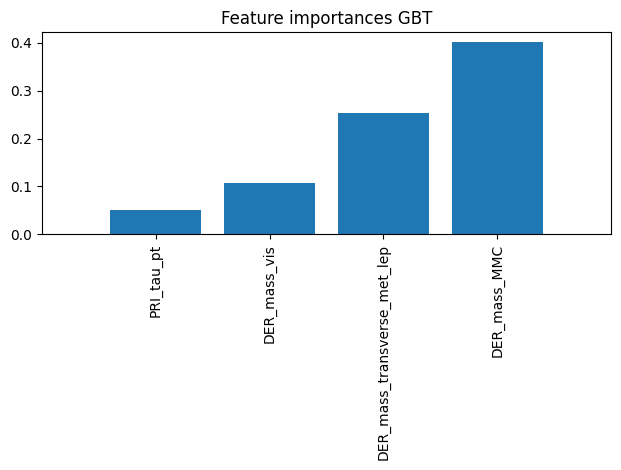

In [75]:
feature_importances = gbt.feature_importances_
sorted_indices = np.argsort(feature_importances)
best_features_index = sorted_indices[-4:]
higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index[::-1]] #this sorts the data by feature

plt.figure()
plt.title("Feature importances GBT")
plt.bar(range(len(best_features_index)), feature_importances[best_features_index[::]], align="center")
plt.xticks(range(len(best_features_index)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index[::]], rotation=90)
plt.xlim([-1, len(best_features_index)])
plt.tight_layout()
plt.show()

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [78]:
# choose your preferred values for the parameters you will test
random_grid = {'n_estimators': [10, 100],
               'max_depth': [3, 10, None],
               'bootstrap': [True, False],
               'max_features': ['sqrt', 'autp']}

In [79]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': ['sqrt', 'autp'],
 'n_estimators': [10, 100]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [80]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=1, cv=3)


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [81]:
random_search.fit(train_x[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    random_state=0),
                   n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': ['sqrt', 'autp'],
                                        'n_estimators': [10, 100]})

In [82]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=10, random_state=0)

In [83]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

n_estimators 100
max_features sqrt
max_depth 10
bootstrap False


In [84]:
rf = RandomForestClassifier(**random_search.best_params_)
pprint(rf.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [85]:
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False, max_depth=10)

In [86]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best score is 0.8324933333333333


In [87]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.474645,0.545473,0.112567,0.008321,100,sqrt,10,False,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.831148,0.822405,0.829676,0.827743,0.003822,1


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

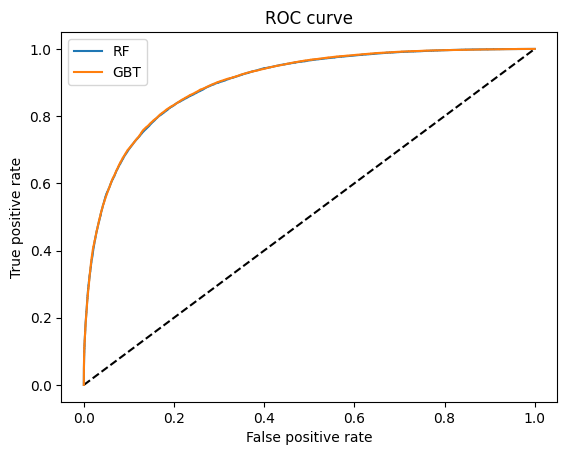

In [90]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()